# HW6 Coding Part

## Problem 0: Set up (0 points)

The following code generates a set of sample points from a two-dimensional Gaussian distribution and displays them as a scatter plot. The distribution is centered at (1.0, 3.0), with its first 2 principal direction are shown in the figure. The standard deviation along this direction is 3, and 1 in the orthogonal direction, resulting in an elliptical spread of the samples that exhibits clear directional structure and scale difference. Here we use PC as the abbreviation for principal component.

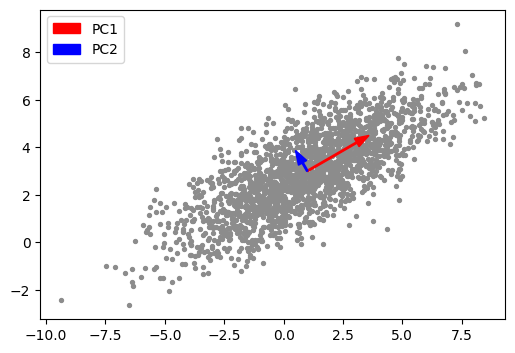

In [1]:
from utils import generate_data
samples = generate_data()

## Problem 1: PCA (5 points)

Now we aim to manually implement PCA using the `samples` data generated in `Problem 0`, and demonstrate the so-called "dimensionality reduction" process.

Although in this case the data remains two-dimensional (i.e., 2D to 2D) and no actual reduction in dimensionality occurs, we still refer to it as "dimensionality reduction" to stay consistent with the terminology used in later sections where true reduction will be performed.

In this problem, your are required to implement PCA by yourself, you can use the `numpy` library to help you with the computation, but you are not allowed to use any built-in functions or libraries that directly perform PCA.

In [2]:
import numpy as np
def PCA(data: np.ndarray, n_components: int = 2):
    # 1. Center the data
    centered_data = data - data.mean(axis=0)

    # 2. Use SVD to compute the eigenvalues and eigenvectors
    U, S, Vt = np.linalg.svd(centered_data, full_matrices=False)

    # 3. Collect the top 'n_components' eigenvectors, and then project the data onto them, and get the projected_data
    projected_data = centered_data @ Vt[:n_components].T

    return projected_data

After implement the PCA algorithm, we can visualize whether the data is successfully reduced to 2D and then project the data onto the principal axes.

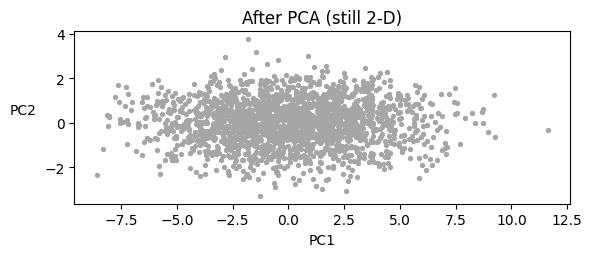

In [3]:
import matplotlib.pyplot as plt

projected_data = PCA(samples, n_components=2)

plt.scatter(projected_data[:, 0], projected_data[:, 1], s=8, color='0.65')
plt.title("After PCA (still 2-D)")
plt.xlabel("PC1"); plt.ylabel("PC2", rotation=0, labelpad=15)
plt.gca().set_aspect("equal")
plt.show()

## Problem 2: Visualize Latent Space (15 points)

PCA is a commonly used technique for reducing high-dimensional data into two or three dimensions for visualization. In the context of neural networks, it can help us understand what high-level features (feature maps) have been learned by projecting them onto a space we can see and interpret.

In this example, we use the LeNet architecture mentioned in Recitation 8 (you can check the network details in utils, or refer to the files on [piazza resources](https://piazza.com/shanghaitech.edu.cn/spring2025/cs182/resources) about recitation 8). After passing through several convolution and pooling layers, each input image is transformed by the fully connected layer fc1 into a high-dimensional representation known as the latent space. This is followed by another fully connected layer fc2 that maps the latent space features to a 10-dimensional output for classification.

A well-trained classifier typically extracts highly informative features in the latent space — that is, the latent features should reflect the class of the input image well. However, since the latent space is often high-dimensional (e.g., 64 dim in ours example), we can’t visualize it directly. To address this, we use PCA to reduce the features to 2D.

If your PCA implementation is correct and the classifier is effective, you should observe that the projected features form clear clusters in 2D space, where samples with the same label are close together and samples with different labels are well separated. We have already trained a well-behavior classifier for you, you can just load the model 'mnist_cnn.pth' to get the models parameters.

Now, please follow the instructions and complete the code to implement this visualization.

load data successfully


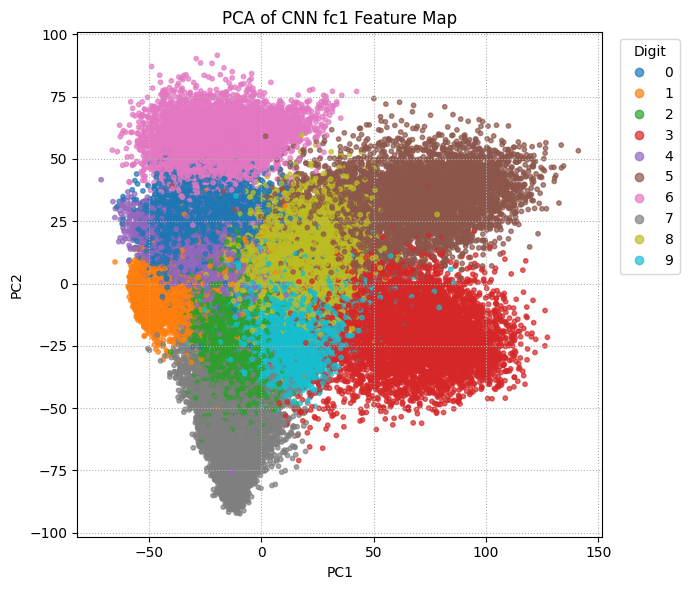

In [4]:
from utils import CNN
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# ---------- load checkpoint ----------
# Load the checkpoint of the CNN model, please make sure you are using a suitable device and model mode
device = "cuda" if torch.cuda.is_available() else "cpu"
model  = CNN().to(device)
ckpt   = torch.load("mnist_cnn.pth", map_location=device)
model.load_state_dict(ckpt)
model.eval()


# ---------- prepare dataset ----------
dataloader = torch.utils.data.DataLoader(datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor()), batch_size=256, shuffle=False)
print("load data successfully")

# ---------- get the features in latent space(features after the layer fc1) for each image ----------
features, labels = [], []

with torch.no_grad():
    for x, y in dataloader:
        # Get the features of the latent space(after the layer fc1), also gather each image's label
        x = x.to(device)
        feature = model.net[:9](x)

        """
        feature = model.net[:9](x) is the same as the following code:
        x = model.maxpool(torch.relu(model.conv1(x)))
        x = model.maxpool(torch.relu(model.conv2(x)))
        x = x.view(x.size(0), -1)
        feature = torch.relu(model.fc1(x))
        """
        features.append(feature.cpu().numpy())
        labels.append(y.numpy())

# concatenate all gathered features and labels, and name them as X and y
X = np.concatenate(features, axis=0)
y = np.concatenate(labels, axis=0)

# Reduce the dimension of the features to 2, and name the reduced features as Z
Z = PCA(X, n_components=2)

# ---------- show the latent space in 2D ----------
plt.figure(figsize=(7, 6))
scatter = plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap='tab10', s=10, alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digit", bbox_to_anchor=(1.02, 1.0))
plt.title("PCA of CNN fc1 Feature Map")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

## Problem 3: K-Means (10 points)

In Problem 2, we used PCA to reduce the high-dimensional latent features extracted by a neural network (such as LeNet) to a two-dimensional space, and successfully visualized how the samples are distributed in that space. We observed that samples belonging to the same class tend to cluster closely in the principal component space, suggesting that the extracted features are quite separable.

Next, we further explore whether it’s possible to distinguish between different classes using only these low-dimensional representations. To do this, we will apply K-Means clustering on the 2D latent features as an unsupervised learning method. K-Means will attempt to partition all the samples into k=10 clusters, each potentially corresponding to an underlying class.

Now, please try implementing it yourself.

In [5]:
import numpy as np
from utils import show_cluster


def kmeans(X, k=10, max_iter=200, tol=1e-4, seed=0):
    rng = np.random.default_rng(seed)
    N = X.shape[0]

    # 1. Initialize: Choose k points as initial centers, you can use any method, a random choice is fine
    centers = X[rng.choice(N, k, replace=False)]

    for t in range(max_iter):
        # 2. Assign each point to the closest center
        distances = np.linalg.norm(X[:, None] - centers[None, :], axis=2)  # (N, k)
        labels = np.argmin(distances, axis=1)  # (N,)

        # 3. visualize the clustering reuslt
        if t < 5 or t % 10 == 0:
            show_cluster(X, centers, labels, t)

        # 4. get the new centers
        new_centers = np.array([X[labels == j].mean(axis=0) if np.any(labels == j) else centers[j] for j in range(k)])

        # 5. calculate the shift distance of the centers
        shift = np.linalg.norm(new_centers - centers)

        # 6. Check whether converged
        if shift < tol:
            show_cluster(X, centers, labels, t)
            print(f"Converged at iteration {t}")
            break

        centers = new_centers

    return centers, labels

Run the K-Means algorithm on the reduced-dim latent space.

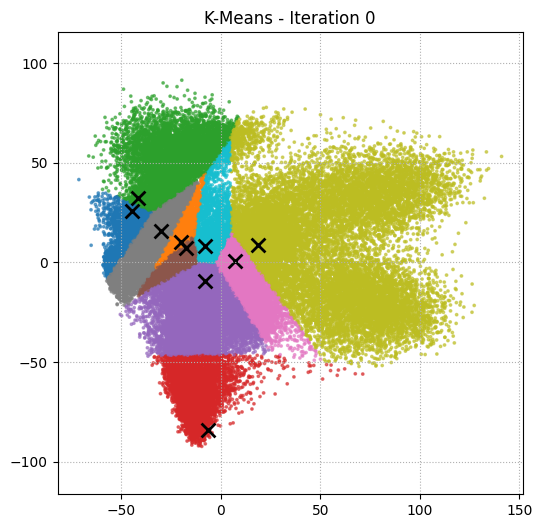

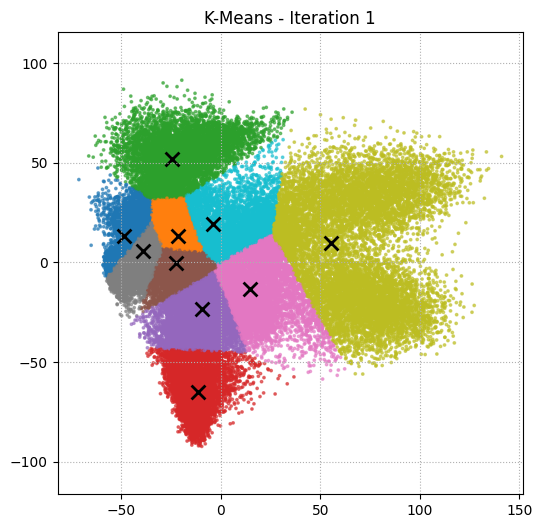

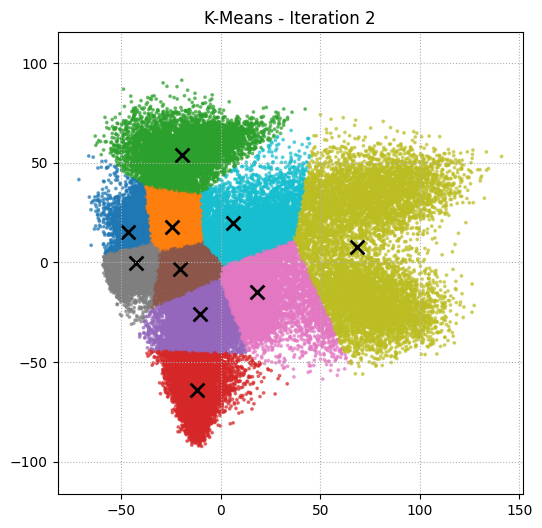

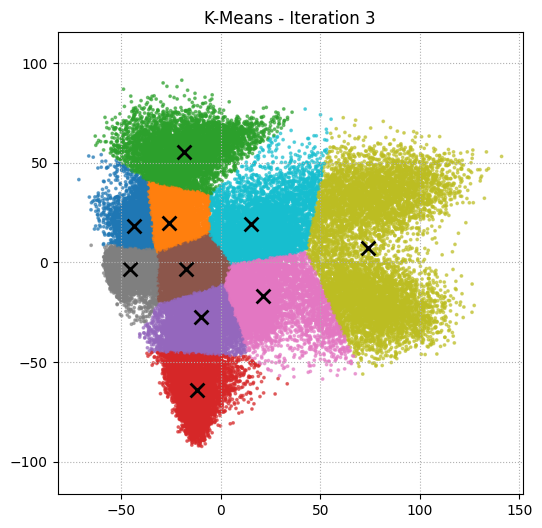

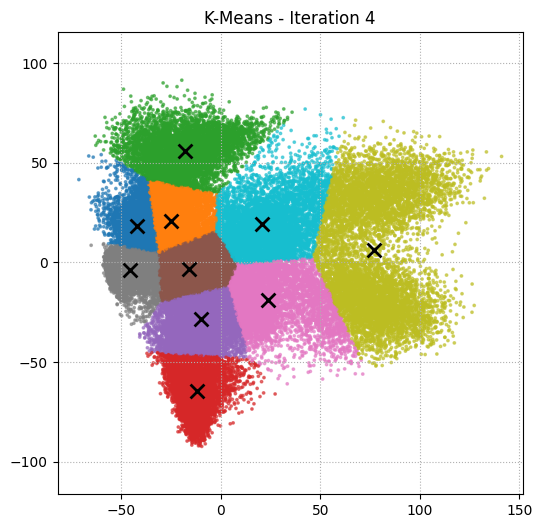

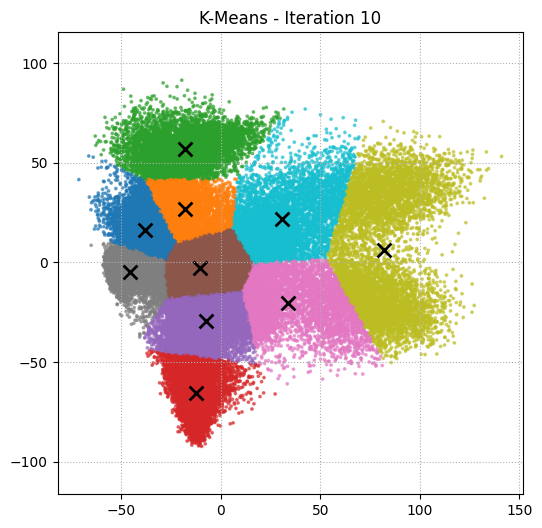

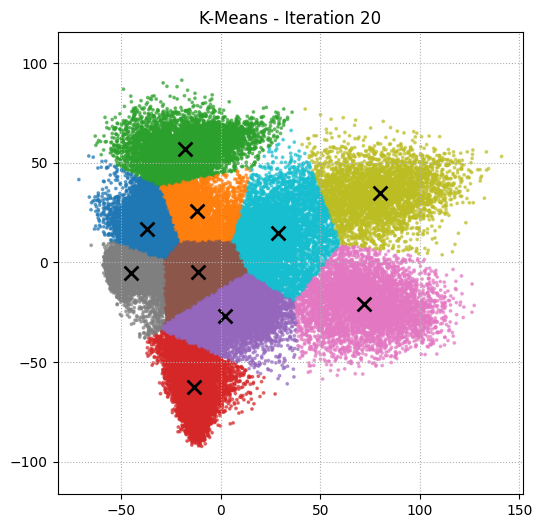

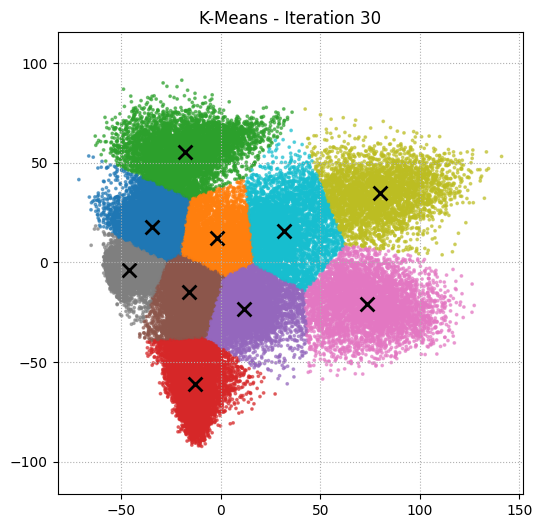

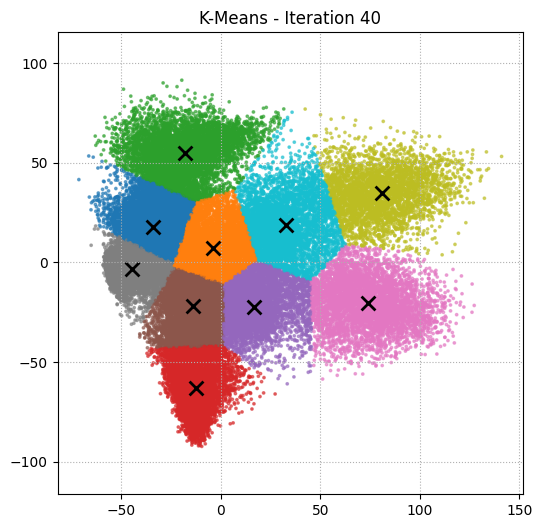

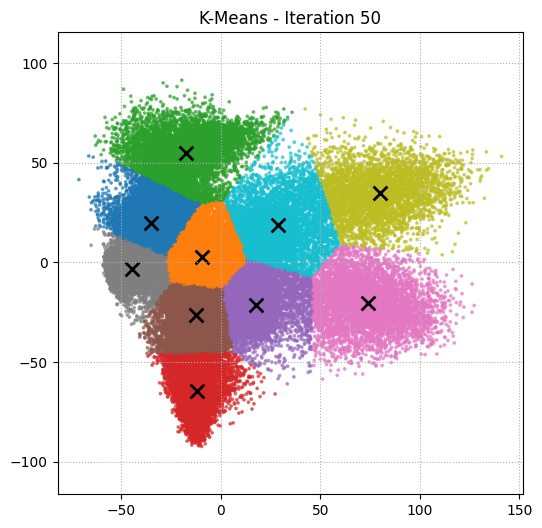

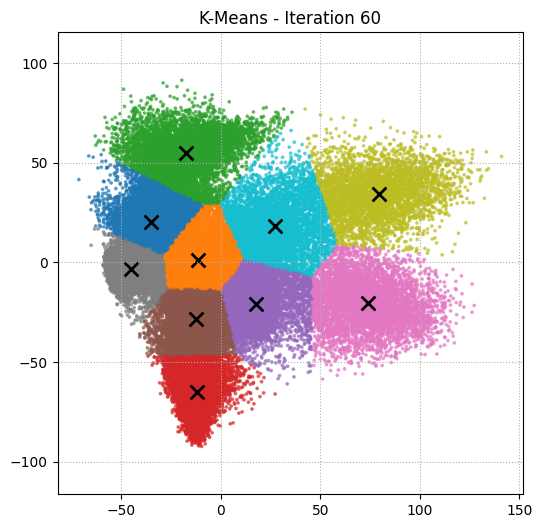

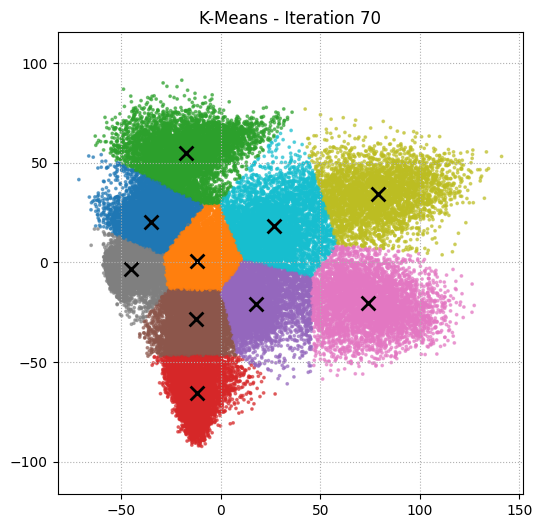

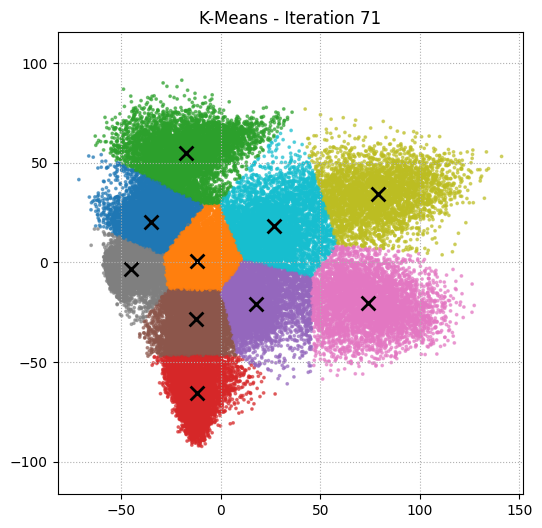

Converged at iteration 71
[[-34.954227   20.116394 ]
 [-11.687625    0.9533492]
 [-17.286106   54.847973 ]
 [-11.998137  -65.40518  ]
 [ 17.580664  -20.842224 ]
 [-12.534429  -28.54152  ]
 [ 73.81898   -20.277565 ]
 [-44.880745   -3.2426016]
 [ 79.25035    34.567898 ]
 [ 26.951994   18.091331 ]]


In [6]:
centers, _ = kmeans(Z)
print(centers)